In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [299]:
# Assuming the file is in the root directory of your Colab environment
try:
  df = pd.read_csv("question4-stock-data.csv")
  print(df.head()) # Display the first few rows of the DataFrame to verify successful import
except FileNotFoundError:
  print("Error: 'question4-stock-data.csv' not found in the root directory.")
except pd.errors.EmptyDataError:
    print("Error: 'question4-stock-data.csv' is empty.")
except pd.errors.ParserError:
    print("Error: 'question4-stock-data.csv' parsing error. Please check file format.")


   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  


In [300]:
# prompt: drop unnamed column from new df

# Drop unnamed columns if they exist
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Date'] = pd.to_datetime(df['Date'])


<ipython-input-300-21a1e6677401>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [292]:
print(df.head())

        Date  Adj Close     Close      High       Low      Open   Volume
0 1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000  41109.0
1 1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0
2 1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606      0.0
3 1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000  10277.0
4 1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   8409.0


In [295]:
print(len(df))

11291


In [296]:
print(df.describe())

                                Date     Adj Close         Close  \
count                          11181  11198.000000  11174.000000   
mean   2002-08-03 13:57:54.429836288     63.609130     72.026945   
min              1980-03-17 00:00:00      2.259452      3.237711   
25%              1991-05-17 00:00:00     19.224636     27.500000   
50%              2002-07-26 00:00:00     50.608900     66.035000   
75%              2013-10-21 00:00:00    104.723621    114.297503   
max              2024-12-27 00:00:00    254.770004    254.770004   
std                              NaN     52.266247     51.259828   

               High           Low          Open        Volume  
count  11196.000000  11164.000000  11188.000000  1.114600e+04  
mean      72.503100     71.665079     67.999259  2.144157e+05  
min        3.237711      3.237711      0.000000  0.000000e+00  
25%       27.789255     27.536156      0.000000  1.350000e+04  
50%       66.724998     65.418751     66.065002  9.032350e+04  
75%

In [297]:
# prompt: gove code to print the number of records with null values or 0 in dataset for each column

# Assuming df is your DataFrame
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")


'Date': Null values - 110, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 117, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 103, Zero values - 2948
'Volume': Null values - 145, Zero values - 131


In [298]:
# Assume df is already defined and 'Date' is converted to datetime.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Identify records with null Date
null_date_records = df[df['Date'].isnull()].copy()

# Counters
gap_one_count = 0
gap_greater_than_one_count = 0

# Dictionaries to store which rows belong to each category
fill_dict = {}           # key: index of the row, value: date to fill (for days_gap == 2)
unaccounted_indexes = [] # indices that don't fit days_gap == 2 or days_gap > 2

for idx in null_date_records.index:
    # If there's no valid previous or next row, it's automatically unaccounted
    if idx <= 0 or idx >= len(df) - 1:
        unaccounted_indexes.append(idx)
        continue

    date_before = df.loc[idx - 1, 'Date']
    date_after  = df.loc[idx + 1, 'Date']

    # If either side is null, we can't fill
    if pd.isnull(date_before) or pd.isnull(date_after):
        unaccounted_indexes.append(idx)
        continue

    # Calculate the gap
    days_gap = (date_after - date_before).days

    if days_gap == 2:
        # There's exactly 1 day in-between
        missing_day = date_before + pd.Timedelta(days=1)
        fill_dict[idx] = missing_day
        gap_one_count += 1
    elif days_gap > 2:
        gap_greater_than_one_count += 1
    else:
        # E.g., days_gap == 1 or days_gap < 2
        unaccounted_indexes.append(idx)

print(f"Number of null-date records with exactly one day gap: {gap_one_count}")
print(f"Number of null-date records with gap greater than one: {gap_greater_than_one_count}")
print(f"Number of unaccounted (leftover) null-date records: {len(unaccounted_indexes)}")

# Actually fill the single-day-gap rows
for row_idx, new_date in fill_dict.items():
    df.loc[row_idx, 'Date'] = new_date

# Print the leftover records
if len(unaccounted_indexes) > 0:
    print("\n=== Leftover null-date records (the 'missing 2') ===")
    print(df.loc[unaccounted_indexes].to_string(index=True))


Number of null-date records with exactly one day gap: 66
Number of null-date records with gap greater than one: 42
Number of unaccounted (leftover) null-date records: 2

=== Leftover null-date records (the 'missing 2') ===
     Date  Adj Close      Close       High        Low       Open    Volume
6125  NaT  61.361324  79.930000  80.669998  79.430000  80.440002  179700.0
6126  NaT  62.336311  81.199997  81.199997  79.900002  80.449997  327100.0


In [221]:
# 1. Convert fill_dict to a list of (row_index, filled_date) pairs
filled_list = list(fill_dict.items())

# 2. (Optional) Sort by row index to ensure chronological order
#    If you already know the insertion order is the order you want, you can skip sorting.
filled_list.sort(key=lambda x: x[0])

# 3. Print only the last five records that were filled
for row_idx, new_date in filled_list[-3:]:
    # Define a safe range (avoid going below 0 or above the last index)
    start_idx = max(0, row_idx - 1)
    end_idx = min(row_idx + 1, len(df) - 1)

    print(f"\n=== Filled Missing Date at row index {row_idx} ===")
    print("Below are the adjacent rows (previous, current, next):")

    subset_cols = ['Date', 'Close', 'Adj Close']
    print(df.loc[start_idx:end_idx, subset_cols].to_string(index=True))



=== Filled Missing Date at row index 9634 ===
Below are the adjacent rows (previous, current, next):
           Date       Close   Adj Close
9633 2018-05-29  126.699997  126.699997
9634 2018-05-30  127.230003  127.230003
9635 2018-05-31  127.970001  127.970001

=== Filled Missing Date at row index 9743 ===
Below are the adjacent rows (previous, current, next):
           Date       Close   Adj Close
9742 2018-10-31  117.050003  117.050003
9743 2018-11-01  117.699997  117.699997
9744 2018-11-02  115.459999  115.459999

=== Filled Missing Date at row index 11256 ===
Below are the adjacent rows (previous, current, next):
            Date       Close   Adj Close
11255 2024-11-06  175.149994  175.149994
11256 2024-11-07  178.449997  178.449997
11257 2024-11-08  172.029999  172.029999


In [222]:
# prompt: gove code to print the number of records with null values or 0 in dataset for each column
# Assuming df is your DataFrame
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 44, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 117, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 103, Zero values - 2948
'Volume': Null values - 145, Zero values - 131


In [223]:
# Optional: Show the region around index 6124-6127
start_check = 6123
end_check = 6128
print("\nSample region after filling:\n")
print(df.loc[start_check:end_check, ['Date','Close','Adj Close']].to_string(index=True))


Sample region after filling:

           Date      Close  Adj Close
6123 2004-06-18  79.300003  60.877697
6124 2004-06-21  80.430000  61.745182
6125        NaT  79.930000  61.361324
6126        NaT  81.199997  62.336311
6127 2004-06-24        NaN  62.013870
6128 2004-06-25  79.760002  61.230824


In [224]:
# Sort by date index if not already sorted
# (If your data is in time order by index, you can skip this or adapt as needed)
df = df.sort_values('Date', na_position='last').reset_index(drop=True)

# Find all indices that have a valid date
valid_date_indices = df[df['Date'].notnull()].index.tolist()

# We’ll store the indices and new dates to fill after we check each “gap”
to_fill = {}

for i in range(len(valid_date_indices) - 1):
    # Current valid row
    idx_start = valid_date_indices[i]
    date_start = df.loc[idx_start, 'Date']

    # Next valid row
    idx_end = valid_date_indices[i + 1]
    date_end = df.loc[idx_end, 'Date']

    # How many days between these two known dates?
    if pd.isnull(date_end) or pd.isnull(date_start):
        continue  # skip if either is invalid

    days_gap = (date_end - date_start).days

    # How many rows are there in between these two?
    # e.g., if idx_start=6124, idx_end=6127, there are 6125 & 6126 in between
    missing_indices = list(range(idx_start + 1, idx_end))
    num_missing_rows = len(missing_indices)

    # If the gap is exactly the number of missing rows + 1,
    # that means we can fill each row with consecutive dates
    # For example, gap=3 days => we need 2 missing rows to fill
    # 2004-06-21, (6125?), (6126?), 2004-06-24
    if days_gap - 1 == num_missing_rows and num_missing_rows > 0:
        print("Filling missing rows with consecutive dates.")
        # We can fill these missing rows with consecutive dates
        # from date_start+1 to date_end-1
        for j, row_idx in enumerate(missing_indices, start=1):
            fill_date = date_start + pd.Timedelta(days=j)
            to_fill[row_idx] = fill_date
            print(f"Filling row index {row_idx} with date {fill_date}")

In [225]:
to_fill

{}

In [226]:
# Optional: Show the region around index 6124-6127
start_check = 6123
end_check = 6128
print("\nSample region after filling:\n")
print(df.loc[start_check:end_check, ['Date','Close','Adj Close']].to_string(index=True))


Sample region after filling:

           Date      Close  Adj Close
6123 2004-07-19  79.070000  60.701115
6124 2004-07-20  78.760002  60.463127
6125 2004-07-21  78.190002  60.025547
6126 2004-07-22  78.230003  60.056252
6127 2004-07-23  77.209999  59.273205
6128 2004-07-26  77.739998  59.680084


In [175]:
# # Actually fill the dates in df
# for idx, fill_date in to_fill.items():
#     print(f"Filling row index {idx} with date {fill_date}")
#     df.loc[idx, 'Date'] = fill_date

# print(f"Filled {len(to_fill)} missing date(s) in the DataFrame.")



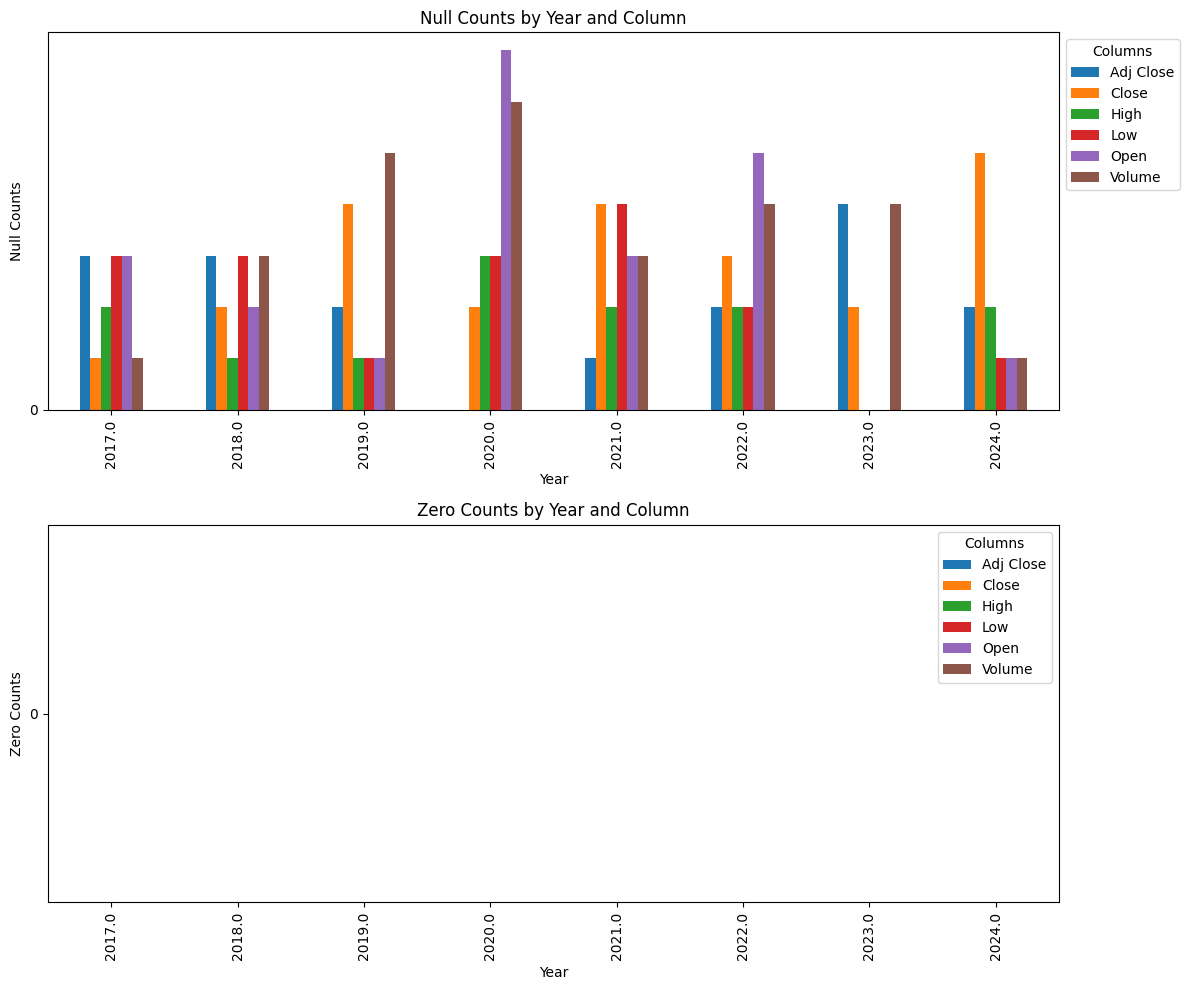

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# -----------------------------
# 0. Basic Setup
# -----------------------------
start_year = 2017
scale = 10  # The step for y-axis ticks
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# Columns to check for null/zero
columns_to_check = [col for col in df.columns if col not in ['Date', 'Year']]

# Identify unique years in ascending order
years = sorted(df['Year'].dropna().unique())

# -----------------------------
# 1. Build Yearly Stats
# -----------------------------
null_counts_table = pd.DataFrame(index=years, columns=columns_to_check, dtype=float)
zero_counts_table = pd.DataFrame(index=years, columns=columns_to_check, dtype=float)
good_values_table = pd.DataFrame(index=years, columns=['GoodValues'], dtype=float)

for year in years:
    if year < start_year:
        continue  # skip years before 2000

    # Filter for that year
    year_df = df[df['Year'] == year]

    # Calculate sums
    null_counts = year_df.isnull().sum()
    zero_counts = (year_df == 0).sum()

    # Good values: total cells minus the number of null cells
    total_cells = year_df.shape[0] * len(year_df.columns)
    good_values = total_cells - year_df.isnull().sum().sum()

    for col in columns_to_check:
        null_counts_table.loc[year, col] = null_counts[col]
        zero_counts_table.loc[year, col] = zero_counts[col]
    good_values_table.loc[year, 'GoodValues'] = good_values

# 2. Filter the summary tables to start from 2000
valid_years = [y for y in years if y >= start_year]
null_counts_table = null_counts_table.loc[valid_years]
zero_counts_table = zero_counts_table.loc[valid_years]
good_values_table = good_values_table.loc[valid_years]

# -----------------------------
# 3. Print Stats
# -----------------------------
for year in valid_years:
    # print(f"\nYear: {year}")
    # print(f"  Good Values (all columns): {int(good_values_table.loc[year, 'GoodValues'])}")
    for col in columns_to_check:
        num_null = int(null_counts_table.loc[year, col])
        num_zero = int(zero_counts_table.loc[year, col])
        # print(f"    Column '{col}': Null={num_null}, Zero={num_zero}")

# -----------------------------
# 4. Plot with Custom Y-Axis Scale
# -----------------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# A) Plot Null Counts
null_counts_table.plot.bar(ax=axes[0], title='Null Counts by Year and Column')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Null Counts')
axes[0].legend(title='Columns', bbox_to_anchor=(1.0, 1.0))

# Set y-axis tick step to 'scale'
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(scale))

# B) Plot Zero Counts
zero_counts_table.plot.bar(ax=axes[1], title='Zero Counts by Year and Column')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Zero Counts')
axes[1].legend(title='Columns', bbox_to_anchor=(1.0, 1.0))

# Same scale for second plot
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(scale))

plt.tight_layout()
plt.show()


In [173]:
# prompt: gove code to print the number of records with null values or 0 in dataset for each column
# Assuming df is your DataFrame
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 44, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 117, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 103, Zero values - 2948
'Volume': Null values - 145, Zero values - 131


In [176]:
# prompt: print thre records where date value is null and give count

# Assuming df is your DataFrame and 'Date' column is already in datetime format
null_date_records = df[df['Date'].isnull()]

# Print the first three records where 'Date' is null
print(null_date_records.head(3))

# Print the count of records where 'Date' is null
print("\nNumber of records with null dates:", len(null_date_records))


      Date  Adj Close     Close      High       Low  Open   Volume
11247  NaT   2.784167  3.989610  4.003658  3.989610   0.0   4449.0
11248  NaT   4.329672  6.204265  6.374244  6.204265   0.0  10884.0
11249  NaT   5.293473  7.585351  7.674590  7.585351   0.0  30256.0

Number of records with null dates: 44


In [231]:
# 2. Create columns for previous day Adj Close and Close
df['Adj_Close_prev'] = df['Adj Close'].shift(1)
df['Close_prev'] = df['Close'].shift(1)
df['Date_prev'] = df['Date'].shift(1)

In [232]:
df = df.iloc[1:]
# Now df contains all rows except the first one
print(df.head())


        Date  Adj Close     Close      High       Low      Open   Volume  \
1 1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0   
2 1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606      0.0   
3 1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000  10277.0   
4 1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   8409.0   
5 1980-03-24   2.371490  3.398259  3.451775  3.398259  0.000000   2803.0   

     Year  Adj_Close_prev  Close_prev  Date_prev  
1  1980.0        2.296798    3.291227 1980-03-17  
2  1980.0        2.306134    3.304606 1980-03-18  
3  1980.0        2.306134    3.304606 1980-03-19  
4  1980.0        2.306134    3.304606 1980-03-20  
5  1980.0        2.362154    3.384880 1980-03-21  


Number of rows filtered out: 210


<ipython-input-251-0bddc975302a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



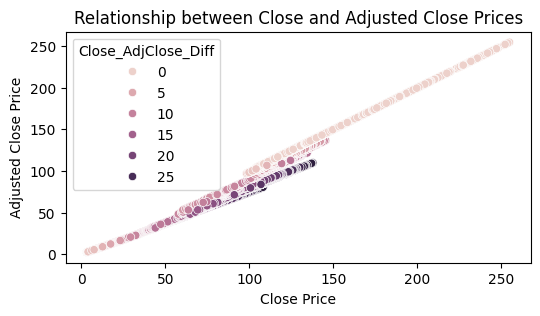


Statistics for the difference between Close and Adjusted Close:
count    11080.000000
mean         8.478970
std          6.880268
min          0.000000
25%          1.750795
50%          8.362733
75%         12.740308
max         27.992645
Name: Close_AdjClose_Diff, dtype: float64

Correlation between Close and Adj Close: 0.9913303832965616


In [251]:
# prompt: get replationship beween Close an Adjuested close for each record if both are notll null and not 0. visaluze it give give stats in numbers too

# Filter out rows where 'Close' or 'Adj Close' are null or zero
filtered_df = df[(df['Close'].notnull()) & (df['Adj Close'].notnull()) & (df['Close'] != 0) & (df['Adj Close'] != 0)]
num_filtered_rows = len(df) - len(filtered_df)

print(f"Number of rows filtered out: {num_filtered_rows}")
# Calculate the difference between 'Close' and 'Adj Close'
filtered_df['Close_AdjClose_Diff'] = filtered_df['Close'] - filtered_df['Adj Close']

# Visualize the relationship
plt.figure(figsize=(6,3))
sns.scatterplot(x='Close', y='Adj Close', data=filtered_df, hue='Close_AdjClose_Diff')
plt.title('Relationship between Close and Adjusted Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Adjusted Close Price')
plt.show()


# Calculate and print statistics
print("\nStatistics for the difference between Close and Adjusted Close:")
print(filtered_df['Close_AdjClose_Diff'].describe())

# Correlation between Close and Adj Close
correlation = filtered_df['Close'].corr(filtered_df['Adj Close'])
print(f"\nCorrelation between Close and Adj Close: {correlation}")


<ipython-input-250-10dfe58718f9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



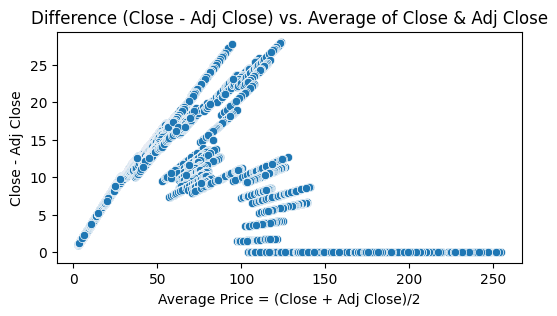

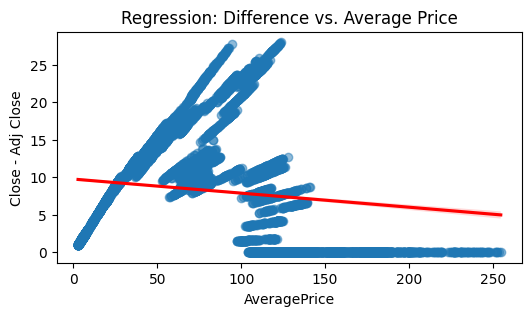

Correlation between (Close - Adj Close) and average price: -0.1406

Statistics for (Close - Adj Close):
count    11080.000000
mean         8.478970
std          6.880268
min          0.000000
25%          1.750795
50%          8.362733
75%         12.740308
max         27.992645
Name: Close_AdjClose_Diff, dtype: float64


In [250]:
# Optionally create an average price metric: (Close + Adj Close) / 2
filtered_df['AveragePrice'] = 0.5 * (filtered_df['Close'] + filtered_df['Adj Close'])

# -------------------------
# 3. Visualize Relationship
# -------------------------
# A. Scatter Plot:
#    difference on the y-axis vs. average on the x-axis
plt.figure(figsize=(6,3))
sns.scatterplot(x='AveragePrice', y='Close_AdjClose_Diff', data=filtered_df)
plt.title('Difference (Close - Adj Close) vs. Average of Close & Adj Close')
plt.xlabel('Average Price = (Close + Adj Close)/2')
plt.ylabel('Close - Adj Close')
plt.show()

# B. Optionally, add a regression line for better visual insight:
plt.figure(figsize=(6,3))
sns.regplot(x='AveragePrice', y='Close_AdjClose_Diff', data=filtered_df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression: Difference vs. Average Price')
plt.xlabel('AveragePrice')
plt.ylabel('Close - Adj Close')
plt.show()

# -------------------------
# 4. Statistics & Correlation
# -------------------------
# Correlation between difference and the average price
corr_diff_avg = filtered_df['Close_AdjClose_Diff'].corr(filtered_df['AveragePrice'])
print(f"Correlation between (Close - Adj Close) and average price: {corr_diff_avg:.4f}")

# Basic descriptive stats of the difference
print("\nStatistics for (Close - Adj Close):")
print(filtered_df['Close_AdjClose_Diff'].describe())

<ipython-input-249-81f857b358c4>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



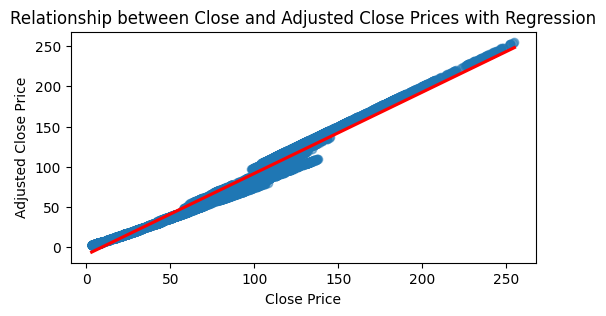


Correlation between Close and Adj Close: 0.9913303832965616


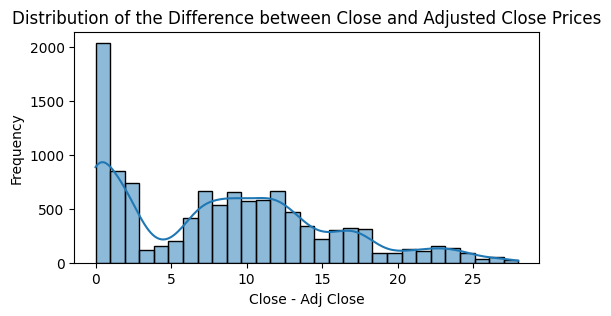


Statistics for the difference between Close and Adjusted Close:
count    11080.000000
mean         8.478970
std          6.880268
min          0.000000
25%          1.750795
50%          8.362733
75%         12.740308
max         27.992645
Name: Close_AdjClose_Diff, dtype: float64


In [249]:
# prompt: i need to understand the relationship Open and adjusted close in a asmilar manner

# Assuming df is your DataFrame and the necessary columns exist

# Calculate the difference between 'Close' and 'Adj Close'
filtered_df['Close_AdjClose_Diff'] = filtered_df['Close'] - filtered_df['Adj Close']

# Visualize the relationship using a scatter plot with a regression line
plt.figure(figsize=(6, 3))
sns.regplot(x='Close', y='Adj Close', data=filtered_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Close and Adjusted Close Prices with Regression')
plt.xlabel('Close Price')
plt.ylabel('Adjusted Close Price')
plt.show()


# Calculate and print the correlation between Close and Adj Close
correlation = filtered_df['Close'].corr(filtered_df['Adj Close'])
print(f"\nCorrelation between Close and Adj Close: {correlation}")

# Further analysis:  Investigate the distribution of the difference
plt.figure(figsize=(6, 3))
sns.histplot(filtered_df['Close_AdjClose_Diff'], kde=True)  # Include a kernel density estimate
plt.title('Distribution of the Difference between Close and Adjusted Close Prices')
plt.xlabel('Close - Adj Close')
plt.ylabel('Frequency')
plt.show()


# Calculate and print statistics for the difference
print("\nStatistics for the difference between Close and Adjusted Close:")
print(filtered_df['Close_AdjClose_Diff'].describe())



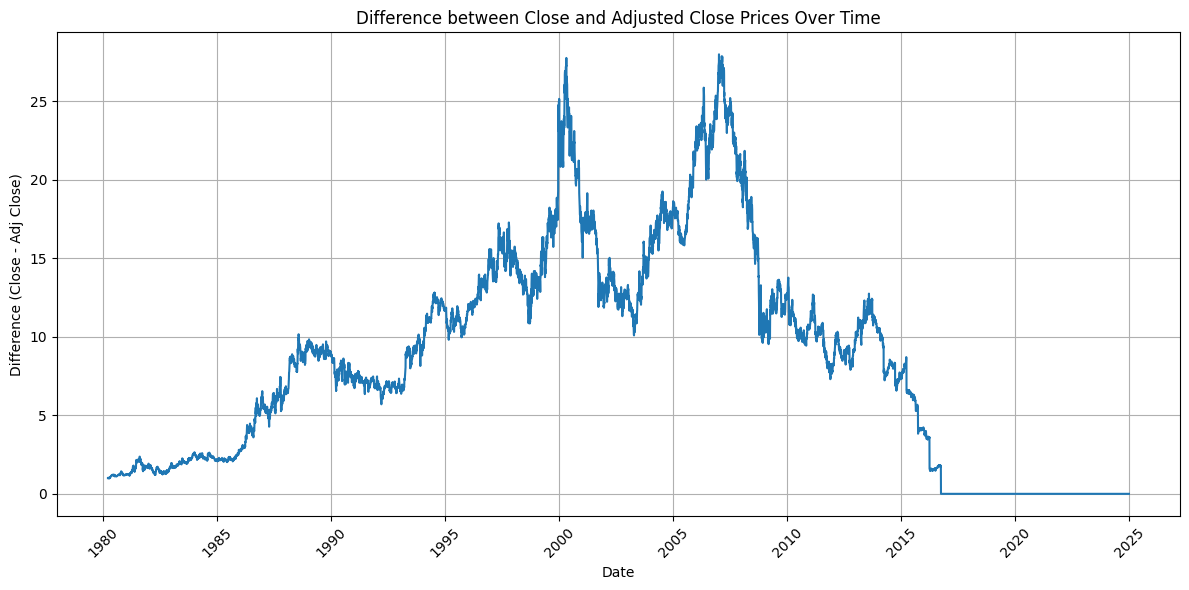

In [236]:
# prompt: i need to visaulze how the differnce varies with the passing of time

import matplotlib.pyplot as plt

# Assuming 'filtered_df' and 'Close_AdjClose_Diff' column exist from previous code

# Visualize the difference over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Close_AdjClose_Diff'])
plt.xlabel('Date')
plt.ylabel('Difference (Close - Adj Close)')
plt.title('Difference between Close and Adjusted Close Prices Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


<ipython-input-288-a1019c24dfb8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



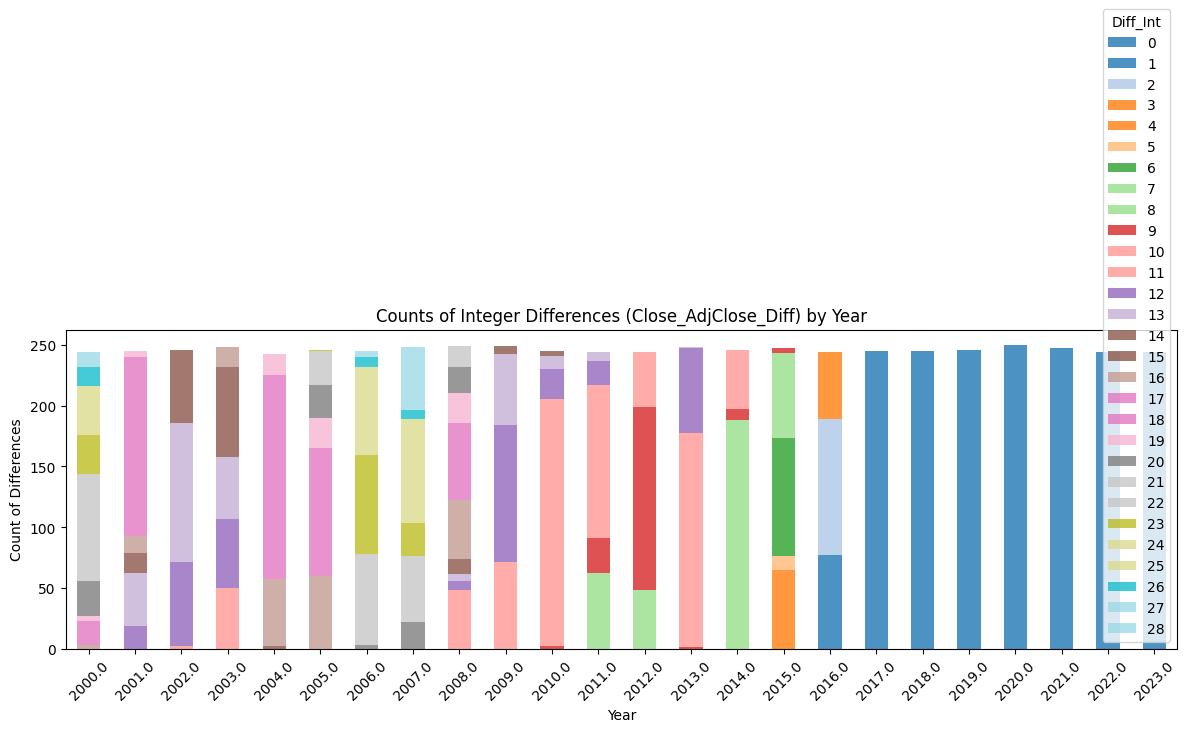

In [288]:
def plot_difference_counts_by_year(df, diff_column='Close_AdjClose_Diff', start_year=2000, end_year=None):
    """
    Plots a bar chart showing the counts of integer differences (Close - Adj Close) by year.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'Date' and the specified 'diff_column' columns.
    diff_column : str, default 'Close_AdjClose_Diff'
        The column containing the differences to analyze.
    start_year : int, default 2000
        The first year to include in the analysis.
    end_year : int, optional
        The last year to include in the analysis. Defaults to the latest year in the DataFrame.
    """

    # Ensure 'Year' column is present
    df['Year'] = df['Date'].dt.year

    # Optionally filter by start and end year
    if end_year is None:
        end_year = int(df['Year'].max())

    df_filtered = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

    # Round the differences to integers
    df_filtered['Diff_Int'] = df_filtered[diff_column].round().astype(int)

    # Get the count of each integer difference per year
    counts_by_year = df_filtered.groupby(['Year', 'Diff_Int']).size().unstack(fill_value=0)

    # Plot a stacked bar chart
    ax = counts_by_year.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        cmap='tab20',  # Use a color map with enough distinct colors
        alpha=0.8
    )
    plt.xlabel('Year')
    plt.ylabel('Count of Differences')
    plt.title(f'Counts of Integer Differences ({diff_column}) by Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_difference_counts_by_year(filtered_df, diff_column='Close_AdjClose_Diff', start_year=2000, end_year=2023)


<ipython-input-237-bcb9f20ea643>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-237-bcb9f20ea643>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



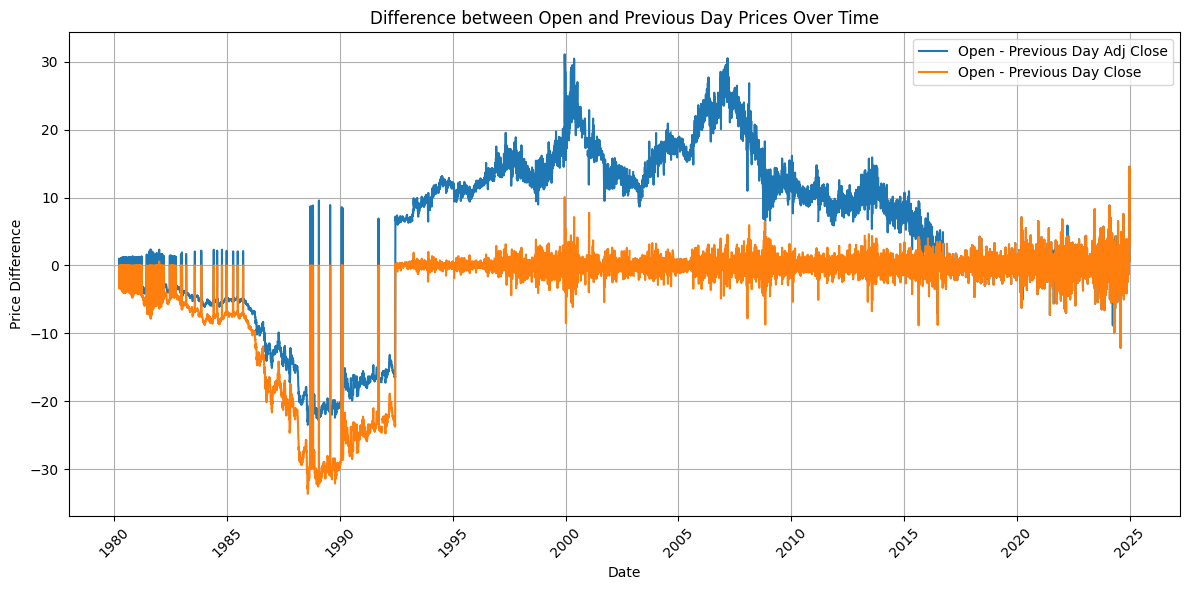

In [237]:
# prompt: i need to visualize the difference bwteen column open and adjusted close vaies with time
filtered_df['Open_AdjClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Adj_Close_prev']
filtered_df['Open_ClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Close_prev']

# Assuming 'filtered_df' and 'Date', 'Close', 'Adj Close' columns exist

plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Open_AdjClosePrev_Diff'], label='Open - Previous Day Adj Close')
plt.plot(filtered_df['Date'], filtered_df['Open_ClosePrev_Diff'], label='Open - Previous Day Close')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Difference between Open and Previous Day Prices Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-238-2d63164402e3>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-238-2d63164402e3>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



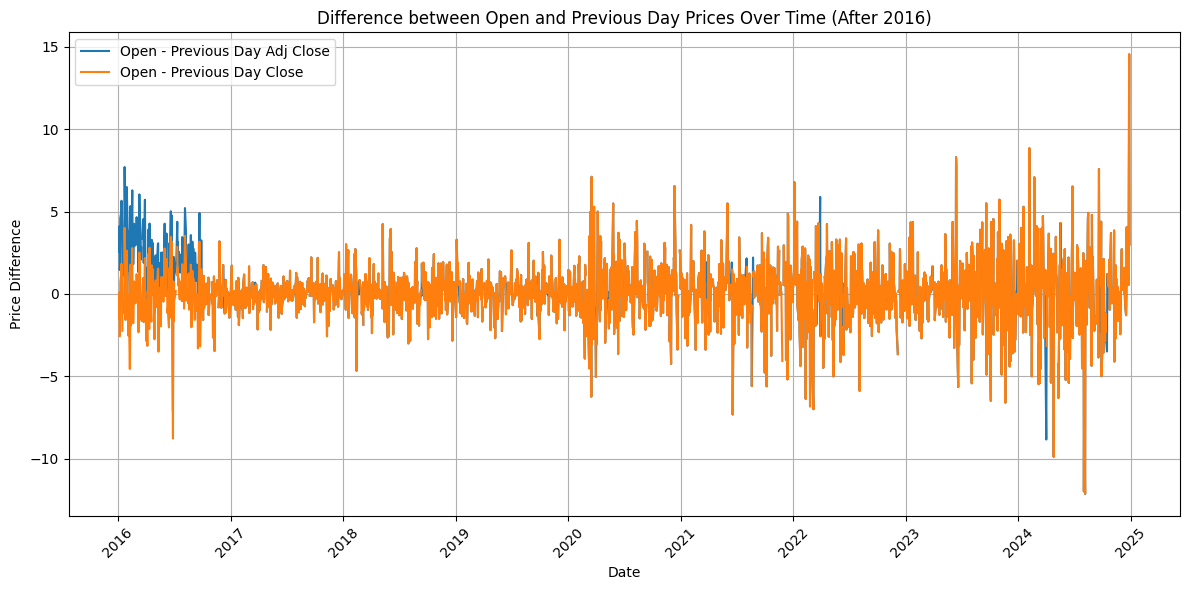

In [238]:
# prompt: i need to visualize the difference bwteen column open and adjusted close vaies with time
filtered_df['Open_AdjClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Adj_Close_prev']
filtered_df['Open_ClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Close_prev']

# Assuming 'filtered_df' and 'Date', 'Close', 'Adj Close' columns exist

# Filter data for dates after 2016
filtered_df_after_2016 = filtered_df[filtered_df['Date'] >= pd.to_datetime('2016-01-01')]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df_after_2016['Date'], filtered_df_after_2016['Open_AdjClosePrev_Diff'], label='Open - Previous Day Adj Close')
plt.plot(filtered_df_after_2016['Date'], filtered_df_after_2016['Open_ClosePrev_Diff'], label='Open - Previous Day Close')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Difference between Open and Previous Day Prices Over Time (After 2016)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [239]:
# Assuming filtered_df is already loaded and processed as in the provided code

# Define the year to filter from
year_after = 2017

# Filter data for dates after the specified year
filtered_df_after_year = filtered_df[filtered_df['Date'] >= pd.to_datetime(str(year_after) + '-01-01')]

# Calculate the difference between 'Close' and 'Adj Close'
filtered_df_after_year['Close_AdjClose_Diff'] = filtered_df_after_year['Close'] - filtered_df_after_year['Adj Close']

# Define the thresholds
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Count records based on the difference
for i in range(len(thresholds)):
    if i == 0:
        count = len(filtered_df_after_year[abs(filtered_df_after_year['Close_AdjClose_Diff']) == thresholds[i]])
        print(f"Number of records where |Close - Adj Close| is equal to {thresholds[i]}: {count}")
    else:
        count = len(filtered_df_after_year[(abs(filtered_df_after_year['Close_AdjClose_Diff']) > thresholds[i-1]) & (abs(filtered_df_after_year['Close_AdjClose_Diff']) <= thresholds[i])])
        print(f"Number of records where {thresholds[i-1]} < |Close - Adj Close| <= {thresholds[i]}: {count}")

# Count records where the difference is greater than the last threshold
count = len(filtered_df_after_year[abs(filtered_df_after_year['Close_AdjClose_Diff']) > thresholds[-1]])
print(f"Number of records where |Close - Adj Close| > {thresholds[-1]}: {count}")

Number of records where |Close - Adj Close| is equal to 0: 1963
Number of records where 0 < |Close - Adj Close| <= 1: 0
Number of records where 1 < |Close - Adj Close| <= 2: 0
Number of records where 2 < |Close - Adj Close| <= 3: 0
Number of records where 3 < |Close - Adj Close| <= 4: 0
Number of records where 4 < |Close - Adj Close| <= 5: 0
Number of records where 5 < |Close - Adj Close| <= 10: 0
Number of records where 10 < |Close - Adj Close| <= 15: 0
Number of records where |Close - Adj Close| > 15: 0


<ipython-input-239-d4ec12733c2f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [240]:
# Assuming filtered_df is already loaded and processed as in the provided code

# Filter data for dates after 2017
filtered_df_after_2017 = filtered_df[filtered_df['Date'] >= pd.to_datetime('2017-01-01')]

# Calculate the difference between 'Open' and previous day's 'Adjusted Close'
filtered_df_after_2017['Open_AdjClosePrev_Diff'] = filtered_df_after_2017['Open'] - filtered_df_after_2017['Adj_Close_prev']

# Define the thresholds
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Count records based on the difference
for i in range(len(thresholds)):
    if i == 0:
        count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) == thresholds[i]])
        print(f"Number of records where |Open - Prev Adj Close| is equal to {thresholds[i]}: {count}")
    else:
        count = len(filtered_df_after_2017[(abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) > thresholds[i-1]) & (abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) <= thresholds[i])])
        print(f"Number of records where {thresholds[i-1]} < |Open - Prev Adj Close| <= {thresholds[i]}: {count}")

# Count records where the difference is greater than the last threshold
count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) > thresholds[-1]])
print(f"Number of records where |Open - Prev Adj Close| > {thresholds[-1]}: {count}")

Number of records where |Open - Prev Adj Close| is equal to 0: 25
Number of records where 0 < |Open - Prev Adj Close| <= 1: 1072
Number of records where 1 < |Open - Prev Adj Close| <= 2: 448
Number of records where 2 < |Open - Prev Adj Close| <= 3: 195
Number of records where 3 < |Open - Prev Adj Close| <= 4: 90
Number of records where 4 < |Open - Prev Adj Close| <= 5: 50
Number of records where 5 < |Open - Prev Adj Close| <= 10: 41
Number of records where 10 < |Open - Prev Adj Close| <= 15: 3
Number of records where |Open - Prev Adj Close| > 15: 0


<ipython-input-240-8725dbd34b4c>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [241]:
import pandas as pd

# Assuming filtered_df is already loaded and processed as in the provided code

def count_price_diff_records(df, year_after, column_name, thresholds):
    """
    Counts records based on price differences within specified thresholds,
    filtering data after a given year.

    Args:
        df: The Pandas DataFrame containing the stock data.
        year_after: The year from which to filter the data.
        column_name: The name of the column containing the price differences.
        thresholds: A list of thresholds for categorizing the differences.

    Returns:
        None (Prints the counts to the console).
    """

    # Filter data for dates after the specified year
    filtered_df_after_year = df[df['Date'] >= pd.to_datetime(str(year_after) + '-01-01')]

    # Count records based on the difference
    for i in range(len(thresholds)):
        if i == 0:
            count = len(filtered_df_after_year[abs(filtered_df_after_year[column_name]) == thresholds[i]])
            print(f"Number of records where |{column_name}| is equal to {thresholds[i]}: {count}")
        else:
            count = len(filtered_df_after_year[(abs(filtered_df_after_year[column_name]) > thresholds[i - 1]) & (abs(filtered_df_after_year[column_name]) <= thresholds[i])])
            print(f"Number of records where {thresholds[i - 1]} < |{column_name}| <= {thresholds[i]}: {count}")

    # Count records where the difference is greater than the last threshold
    count = len(filtered_df_after_year[abs(filtered_df_after_year[column_name]) > thresholds[-1]])
    print(f"Number of records where |{column_name}| > {thresholds[-1]}: {count}")

In [242]:
# Assuming filtered_df is already loaded and processed, and count_price_diff_records function is defined

# Define the range of years
start_year = 2017
end_year = int(filtered_df['Date'].dt.year.max())  # Get the last year in your data and convert to int

# Define the column name and thresholds
column_name = 'Open_AdjClosePrev_Diff'
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Calculate the difference between 'Open' and previous day's 'Adjusted Close'
filtered_df['Open_AdjClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Adj_Close_prev']

# Call the function for each year
for year in range(start_year, end_year + 1):
    print(f"\nAnalysis for year: {year}")
    count_price_diff_records(filtered_df, year, column_name, thresholds)


Analysis for year: 2017
Number of records where |Open_AdjClosePrev_Diff| is equal to 0: 25
Number of records where 0 < |Open_AdjClosePrev_Diff| <= 1: 1072
Number of records where 1 < |Open_AdjClosePrev_Diff| <= 2: 448
Number of records where 2 < |Open_AdjClosePrev_Diff| <= 3: 195
Number of records where 3 < |Open_AdjClosePrev_Diff| <= 4: 90
Number of records where 4 < |Open_AdjClosePrev_Diff| <= 5: 50
Number of records where 5 < |Open_AdjClosePrev_Diff| <= 10: 41
Number of records where 10 < |Open_AdjClosePrev_Diff| <= 15: 3
Number of records where |Open_AdjClosePrev_Diff| > 15: 0

Analysis for year: 2018
Number of records where |Open_AdjClosePrev_Diff| is equal to 0: 22
Number of records where 0 < |Open_AdjClosePrev_Diff| <= 1: 873
Number of records where 1 < |Open_AdjClosePrev_Diff| <= 2: 417
Number of records where 2 < |Open_AdjClosePrev_Diff| <= 3: 189
Number of records where 3 < |Open_AdjClosePrev_Diff| <= 4: 90
Number of records where 4 < |Open_AdjClosePrev_Diff| <= 5: 50
Number

<ipython-input-242-ed886d4581c3>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [277]:
def plot_open_adjclose_diff_distribution(
    df,
    start_year,
    end_year,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=None
):
    """
    Plots the distribution of abs(Open - Adj_Close_prev) by year, binned by specified thresholds.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing 'Date', 'Open', and 'Adj_Close_prev'.
    start_year : int
        The first year to include in the plot.
    end_year : int
        The last year to include in the plot.
    column_name : str, default 'Open_AdjClosePrev_Diff'
        The name of the column to store the difference (Open - Adj_Close_prev).
    thresholds : list, default [0, 1, 2, 3, 4, 5, 10, 15]
        The list of numeric cutoffs for binning the absolute difference.
        The first bin checks == thresholds[0].
        The subsequent bins are (thresholds[i-1], thresholds[i]].
        Finally, there's one bin for > thresholds[-1].
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if thresholds is None:
        thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

    # Calculate the difference (Open - Adj_Close_prev) if not already calculated
    if column_name not in df.columns:
        df[column_name] = df['Open'] - df['Adj_Close_prev']
    else:
        # If it exists but needs updating, do so
        df[column_name] = df['Open'] - df['Adj_Close_prev']

    # Dictionary to store counts for each year: { year: [counts for each bin], ... }
    all_counts = {}

    # Loop through years in the specified range
    years_to_check = range(start_year, end_year + 1)
    for year in years_to_check:
        # Filter only the records for this specific year
        df_year = df[df['Date'].dt.year == year]

        # List to hold the bin counts in the order of thresholds
        counts_for_year = []

        # Bins:
        #   - bin #1: abs(difference) == 0
        #   - bin #2: abs(difference) in (0, 1]
        #   - bin #3: abs(difference) in (1, 2]
        #   ... up to your largest threshold
        for i in range(len(thresholds)):
            if i == 0:
                # Exactly == thresholds[0]
                count = len(df_year[abs(df_year[column_name]) == thresholds[i]])
            else:
                # (thresholds[i-1], thresholds[i]]
                count = len(df_year[
                    (abs(df_year[column_name]) > thresholds[i - 1]) &
                    (abs(df_year[column_name]) <= thresholds[i])
                ])
            counts_for_year.append(count)

        # Final bin: > thresholds[-1]
        count = len(df_year[abs(df_year[column_name]) > thresholds[-1]])
        counts_for_year.append(count)

        # Store the counts for this year
        all_counts[year] = counts_for_year

    # Prepare labels for the bins
    threshold_labels = (
        [f"=={thresholds[0]}"] +
        [f"({thresholds[i-1]}, {thresholds[i]}]" for i in range(1, len(thresholds))] +
        [f">{thresholds[-1]}"]
    )

    # Create the bar chart
    bar_width = 0.15
    x_positions = np.arange(len(threshold_labels))

    fig, ax = plt.subplots(figsize=(20, 6))
    sorted_years = sorted(all_counts.keys())

    for i, year in enumerate(sorted_years):
        ax.bar(
            x_positions + i * bar_width,
            all_counts[year],
            width=bar_width,
            label=str(year)
        )

    ax.set_xticks(x_positions + (len(sorted_years) - 1) * bar_width / 2)
    ax.set_xticklabels(threshold_labels)
    ax.set_xlabel('Absolute Price Difference Bins')
    ax.set_ylabel('Number of Records')
    ax.set_title('Distribution of Differences of Open and Adj_Close_prev by Year')
    ax.legend()
    plt.tight_layout()
    plt.show()


<ipython-input-277-ea7ebbb2effe>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



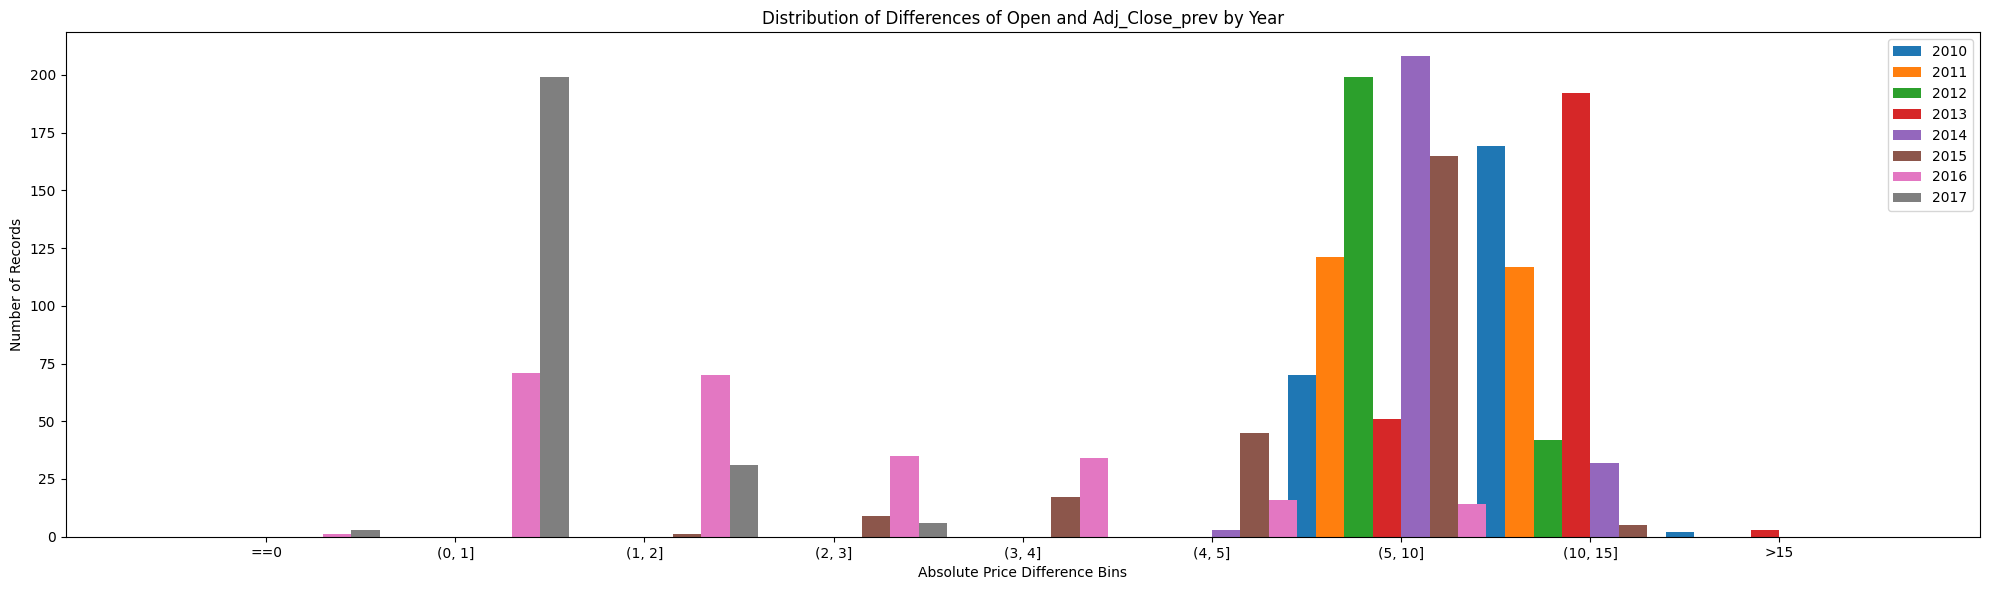

In [278]:
# Example usage:
plot_open_adjclose_diff_distribution(
    df=filtered_df,
    start_year=2010,
    end_year=2017,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=[0, 1, 2, 3, 4, 5, 10, 15]
)


<ipython-input-277-ea7ebbb2effe>:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



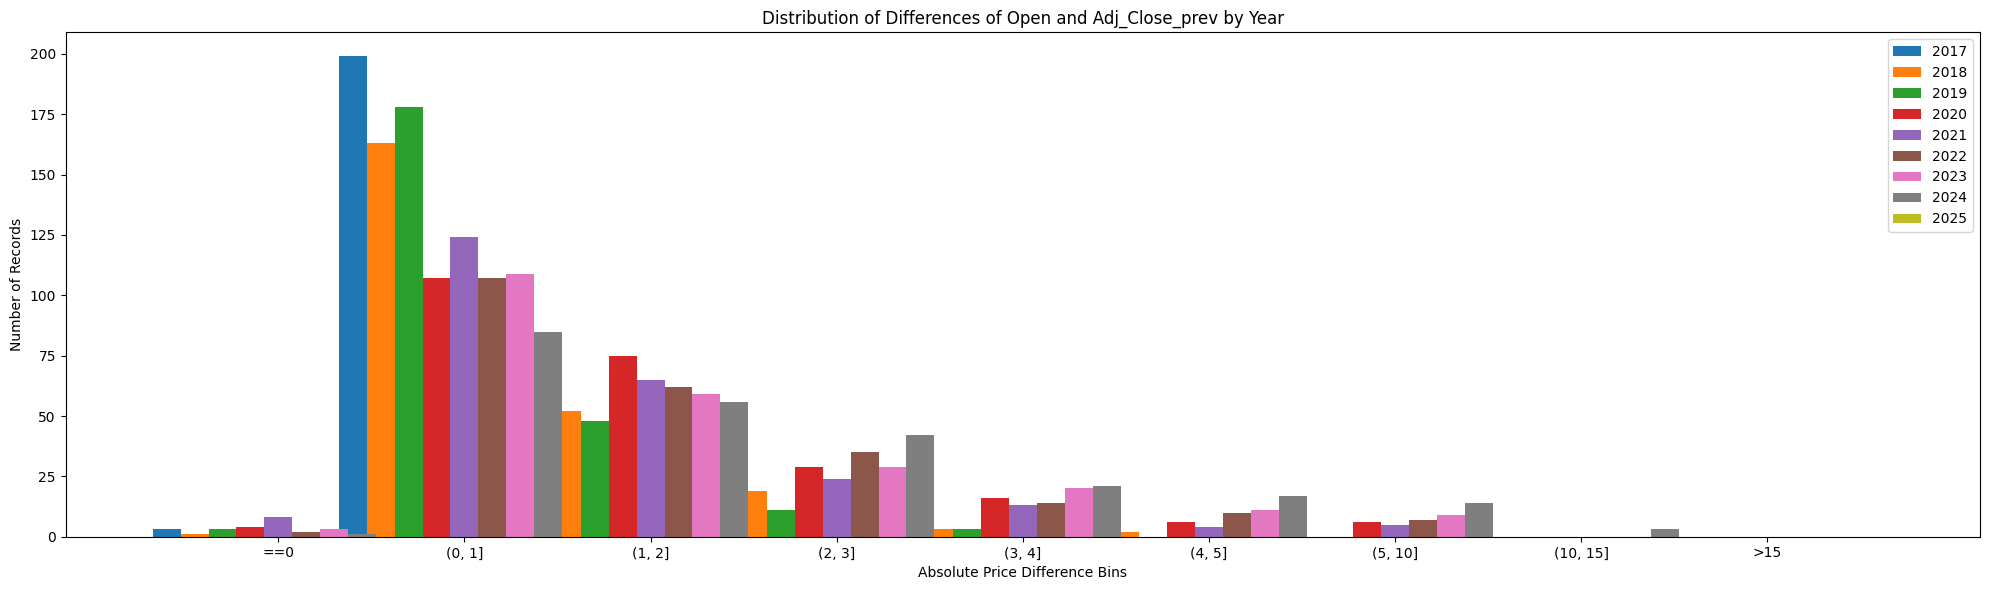

In [279]:
# Example usage:
plot_open_adjclose_diff_distribution(
    df=filtered_df,
    start_year=2017,
    end_year=2025,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=[0, 1, 2, 3, 4, 5, 10, 15]
)


In [254]:
# Group data by year and count the number of records
record_counts_by_year = filtered_df.groupby(filtered_df['Date'].dt.year).size()

# Filter record counts for years after 2020
record_counts_after_2020 = record_counts_by_year[record_counts_by_year.index > 2017]

# Print the record counts after 2020
print(record_counts_after_2020)

Date
2018.0    245
2019.0    246
2020.0    250
2021.0    247
2022.0    244
2023.0    244
2024.0    242
dtype: int64


In [265]:
# Assuming filtered_df is already loaded and processed as in the provided code

# Filter data for dates after 2017
filtered_df_after_2017 = filtered_df[filtered_df['Date'] >= pd.to_datetime('2017-01-01')]

# Calculate the difference between 'Open' and previous day's 'Adjusted Close'
filtered_df_after_2017['Open_AdjClosePrev_Diff'] = filtered_df_after_2017['Open'] - filtered_df_after_2017['Adj_Close_prev']

# Calculate the percentage difference relative to previous day's 'Adjusted Close'
filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct'] = (filtered_df_after_2017['Open_AdjClosePrev_Diff'] / filtered_df_after_2017['Adj_Close_prev']) * 100

# Define the thresholds (now in percentage)
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Count records based on the percentage difference
for i in range(len(thresholds)):
    if i == 0:
        count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) == thresholds[i]])
        print(f"Number of records where |Open - Prev Adj Close| is equal to {thresholds[i]}%: {count}")
    else:
        count = len(filtered_df_after_2017[(abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) > thresholds[i-1]) & (abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) <= thresholds[i])])
        print(f"Number of records where {thresholds[i-1]}% < |Open - Prev Adj Close| <= {thresholds[i]}%: {count}")

# Count records where the percentage difference is greater than the last threshold
count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) > thresholds[-1]])
print(f"Number of records where |Open - Prev Adj Close| > {thresholds[-1]}%: {count}")

Number of records where |Open - Prev Adj Close| is equal to 0%: 25
Number of records where 0% < |Open - Prev Adj Close| <= 1%: 1335
Number of records where 1% < |Open - Prev Adj Close| <= 2%: 405
Number of records where 2% < |Open - Prev Adj Close| <= 3%: 114
Number of records where 3% < |Open - Prev Adj Close| <= 4%: 28
Number of records where 4% < |Open - Prev Adj Close| <= 5%: 11
Number of records where 5% < |Open - Prev Adj Close| <= 10%: 6
Number of records where 10% < |Open - Prev Adj Close| <= 15%: 0
Number of records where |Open - Prev Adj Close| > 15%: 0


<ipython-input-265-795d68e45c33>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-265-795d68e45c33>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [282]:
def plot_integer_differences_for_year(df, year, diff_col_name='Open_AdjClosePrev_Diff'):
    """
    Plots a bar chart showing the integer counts of (Open - Adj_Close_prev) for a single year.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing at least 'Date', 'Open', and 'Adj_Close_prev' columns.
        Assumes df['Date'] is already in datetime format.
    year : int
        The year of interest (e.g., 2022).
    diff_col_name : str, optional
        Column name to store the difference (default 'Open_AdjClosePrev_Diff').
    """

    # 1. Filter data to the specific year
    df_year = df[df['Date'].dt.year == year].copy()

    # 2. Calculate the difference (Open - Adj_Close_prev) if not already present
    if diff_col_name not in df_year.columns:
        df_year[diff_col_name] = df_year['Open'] - df_year['Adj_Close_prev']
    else:
        df_year[diff_col_name] = df_year['Open'] - df_year['Adj_Close_prev']

    # 3. Identify problematic rows before conversion
    problematic_rows = df_year[
        ~np.isfinite(df_year[diff_col_name]) | df_year[diff_col_name].isnull()
    ]

    if not problematic_rows.empty:
        print(f"\nFound {len(problematic_rows)} problematic records in {year}:")
        print(problematic_rows[['Date', 'Open', 'Adj_Close_prev', diff_col_name]].to_string(index=True))

    # 4. Handle non-finite values (NaN, inf) before converting to integer
    df_year[diff_col_name] = df_year[diff_col_name].replace([np.inf, -np.inf], np.nan)
    df_year[diff_col_name] = df_year[diff_col_name].fillna(0)  # Replace NaNs with 0 (or another value)

    # 5. Convert the difference to integer
    df_year[diff_col_name] = df_year[diff_col_name].round().astype(int)

    # 6. Count the occurrences of each integer difference
    difference_counts = df_year[diff_col_name].value_counts().sort_index()

    # 7. Plot the integer difference counts
    difference_counts.plot(
        kind='bar',
        figsize=(6, 3),
        title=f'Integer Differences (Open - Adj_Close_prev) in {year}',
        xlabel='Difference (Integer)',
        ylabel='Count of Records'
    )
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



Found 5 problematic records in 2015:
           Date   Open  Adj_Close_prev  Open_AdjClosePrev_Diff
8768 2015-02-06    NaN      123.845696                     NaN
8801 2015-03-26  143.0             NaN                     NaN
8842 2015-05-26    NaN      131.790237                     NaN
8916 2015-09-09    NaN      115.600121                     NaN
8981 2015-12-10  125.0             NaN                     NaN


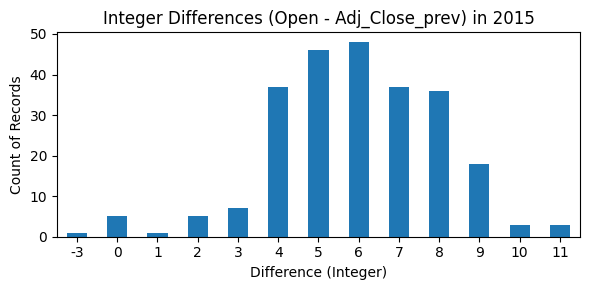

In [283]:
plot_integer_differences_for_year(filtered_df, 2015)


Found 3 problematic records in 2016:
           Date        Open  Adj_Close_prev  Open_AdjClosePrev_Diff
9047 2016-03-18  106.279999             NaN                     NaN
9201 2016-10-28         NaN      114.849998                     NaN
9217 2016-11-21         NaN      114.040001                     NaN


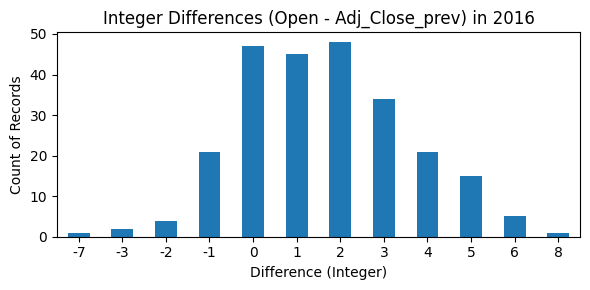

In [284]:
plot_integer_differences_for_year(filtered_df, 2016)


Found 6 problematic records in 2017:
           Date        Open  Adj_Close_prev  Open_AdjClosePrev_Diff
9313 2017-04-12         NaN      106.400002                     NaN
9323 2017-04-27  109.800003             NaN                     NaN
9371 2017-07-06  108.070000             NaN                     NaN
9419 2017-09-13         NaN      116.540001                     NaN
9442 2017-10-16         NaN      123.379997                     NaN
9481 2017-12-13  124.730003             NaN                     NaN


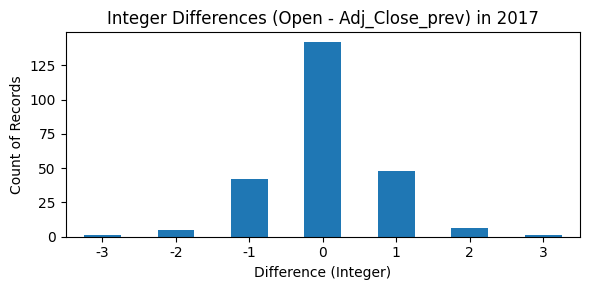

In [285]:
plot_integer_differences_for_year(filtered_df, 2017)